# Create Model

## Packages

In [8]:
from gensim.models import Word2Vec
import json
import numpy as np
import pandas as pd

In [34]:

with open('../../assets/word_index.json', 'r') as f:
    word_index = json.load(f)
    word_index = dict(word_index)

train = pd.read_csv('../../assets/data/train/padded.csv')
val = pd.read_csv('../../assets/data/val/padded.csv')

X_train = train.to_numpy()[:, :-1]
y_train = train.to_numpy()[:, -1]

X_val = val.to_numpy()[:, :-1]
y_val = val.to_numpy()[:, -1]

In [35]:
max_len = X_train.shape[1]

## Load word2vec model

In [36]:
model = Word2Vec.load('../../assets/word2vec.model')

model.wv.most_similar('petrobras')

[('petr4', 0.9969706535339355),
 ('venda', 0.9732074737548828),
 ('diz', 0.9684100151062012),
 ('arrecada', 0.9663283824920654),
 ('sal', 0.9640135169029236),
 ('natural', 0.9576036334037781),
 ('premenos', 0.9558805227279663),
 ('inicia', 0.9553847312927246),
 ('bolsonaro', 0.9515899419784546),
 ('governo', 0.9483191967010498)]

In [37]:
# List of nparrays of size 300
embeddings_dict = {}
for i, word in enumerate(model.wv.index_to_key):
    embeddings_dict[word] = model.wv[word]

In [38]:
# create matrix with vocab train words
embeddings_on_this_context = np.zeros((len(word_index), 300))
for word, i in word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_on_this_context[i - 1] = embeddings_vector

## RNN Model

### Packages

In [39]:
import seaborn as sns

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

import matplotlib.pyplot as plt

### Functions

In [40]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

### Declaration

In [41]:
model = Sequential([
    Embedding(input_dim=len(word_index), output_dim= 300, input_length=max_len, trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(64, return_sequences=True)),
    # Dropout(0.4),
    # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    # Dropout(0.6),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 300)           2406300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,696,223
Trainable params: 289,923
Non-

### Training

In [18]:
# loss = BinaryCrossentropy(from_logits=False)
# optimizer = Adam(0.0001)
# metrics = ['accuracy']
# model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
#
# history = model.fit(train_padded, y_train, epochs=30, validation_data=(val_padded,y_val), verbose=2)


In [42]:
from keras.optimizers import SGD

loss = "sparse_categorical_crossentropy"
optimizer = SGD(learning_rate=0.01)
metrics = ['accuracy']


In [43]:
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val,y_val), verbose=2)


Epoch 1/25
299/299 - 15s - loss: 1.0113 - accuracy: 0.5083 - val_loss: 0.9627 - val_accuracy: 0.5401 - 15s/epoch - 51ms/step
Epoch 2/25
299/299 - 7s - loss: 0.9566 - accuracy: 0.5478 - val_loss: 0.9031 - val_accuracy: 0.6179 - 7s/epoch - 25ms/step
Epoch 3/25
299/299 - 7s - loss: 0.9003 - accuracy: 0.6193 - val_loss: 0.8495 - val_accuracy: 0.6547 - 7s/epoch - 24ms/step
Epoch 4/25
299/299 - 7s - loss: 0.8516 - accuracy: 0.6382 - val_loss: 0.8087 - val_accuracy: 0.6614 - 7s/epoch - 24ms/step
Epoch 5/25
299/299 - 8s - loss: 0.8185 - accuracy: 0.6486 - val_loss: 0.7818 - val_accuracy: 0.6689 - 8s/epoch - 26ms/step
Epoch 6/25
299/299 - 7s - loss: 0.7896 - accuracy: 0.6621 - val_loss: 0.7447 - val_accuracy: 0.6982 - 7s/epoch - 25ms/step
Epoch 7/25
299/299 - 8s - loss: 0.7584 - accuracy: 0.6793 - val_loss: 0.7093 - val_accuracy: 0.7124 - 8s/epoch - 28ms/step
Epoch 8/25
299/299 - 8s - loss: 0.7275 - accuracy: 0.6955 - val_loss: 0.7043 - val_accuracy: 0.6957 - 8s/epoch - 27ms/step
Epoch 9/25
299

### Evaluation

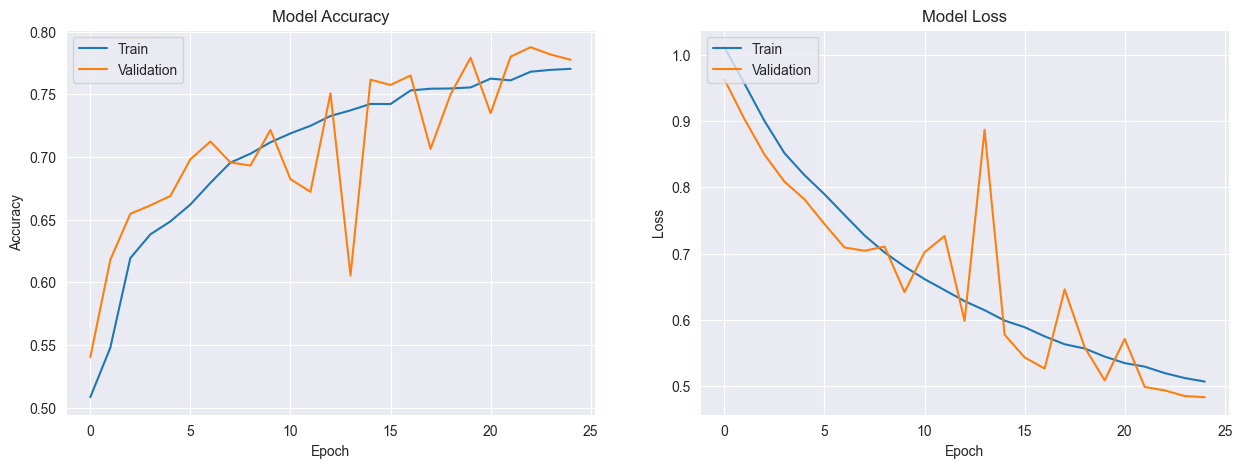

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
model.save('../../assets/lstm_model')

INFO:tensorflow:Assets written to: ../../assets/lstm_model\assets


INFO:tensorflow:Assets written to: ../../assets/lstm_model\assets
